## Data quality check / cleaning / preparation 

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.** An example is given below.

In [44]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")

OnlineNewsPopularity = pd.read_csv("OnlineNewsPopularity.csv")

In [45]:
from sklearn.model_selection import cross_val_score,train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    OnlineNewsPopularity.drop([' shares', 'url'], axis = 1),
    OnlineNewsPopularity[' shares'],
    test_size = 0.2,
    random_state = 42)

In [46]:
clean = OnlineNewsPopularity.drop(['url'], axis = 1)

### Distribution of response
*By Daniel He*

<AxesSubplot:xlabel=' shares', ylabel='Density'>

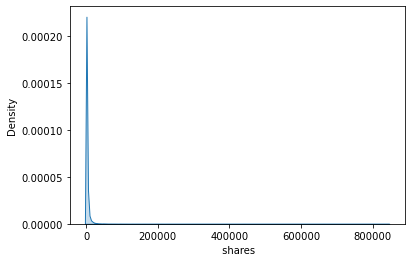

In [47]:
# Heavily skewed, will try logging the response variable
response_clean = clean[' shares']
sns.kdeplot(response_clean, fill=True, bw_method = .1)

### Data cleaning
*By Sarah Hsu*

In [48]:
data = OnlineNewsPopularity.rename(columns={'url': 'url', ' timedelta': 'timedelta', ' n_tokens_title': "n_tokens_title", ' n_tokens_content': 'n_tokens_content',
       ' n_unique_tokens': 'n_unique_tokens', ' n_non_stop_words': 'n_non_stop_words', ' n_non_stop_unique_tokens': 'n_non_stop_unique_tokens',
       ' num_hrefs': 'num_hrefs', ' num_self_hrefs': 'num_self_hrefs', ' num_imgs': 'num_imgs', ' num_videos': 'num_videos',
       ' average_token_length': 'average_token_length', ' num_keywords': 'num_keywords', ' data_channel_is_lifestyle': 'data_channel_is_lifestyle',
       ' data_channel_is_entertainment': 'data_channel_is_entertainment', ' data_channel_is_bus': 'data_channel_is_bus',
       ' data_channel_is_socmed': 'data_channel_is_socmed', ' data_channel_is_tech': 'data_channel_is_tech',
       ' data_channel_is_world': 'data_channel_is_world', ' kw_min_min': 'kw_min_min', ' kw_max_min': 'kw_max_min', ' kw_avg_min': 'kw_avg_min',
       ' kw_min_max': 'kw_min_max', ' kw_max_max': 'kw_max_max', ' kw_avg_max': 'kw_avg_max', ' kw_min_avg': 'kw_min_avg',
       ' kw_max_avg': 'kw_max_avg', ' kw_avg_avg': 'kw_avg_avg', ' self_reference_min_shares': 'self_reference_min_shares',
       ' self_reference_max_shares': 'self_reference_max_shares', ' self_reference_avg_sharess': 'self_reference_avg_sharess',
       ' weekday_is_monday': 'weekday_is_monday', ' weekday_is_tuesday': 'weekday_is_tuesday', ' weekday_is_wednesday': 'weekday_is_wednesday',
       ' weekday_is_thursday': 'weekday_is_thursday', ' weekday_is_friday': 'weekday_is_friday', ' weekday_is_saturday': 'weekday_is_saturday',
       ' weekday_is_sunday': 'weekday_is_sunday', ' is_weekend': 'is_weekend', ' LDA_00': 'LDA_00', ' LDA_01': 'LDA_01', ' LDA_02': 'LDA_02',
       ' LDA_03': 'LDA_03', ' LDA_04': 'LDA_04', ' global_subjectivity': 'global_subjectivity',
       ' global_sentiment_polarity': 'global_sentiment_polarity', ' global_rate_positive_words': 'global_rate_positive_words',
       ' global_rate_negative_words': 'global_rate_negative_words', ' rate_positive_words' : 'rate_positive_words',
       ' rate_negative_words': 'rate_negative_words', ' avg_positive_polarity': 'avg_positive_polarity',
       ' min_positive_polarity': 'min_positive_polarity', ' max_positive_polarity': 'max_positive_polarity',
       ' avg_negative_polarity': 'avg_negative_polarity', ' min_negative_polarity': 'min_negative_polarity',
       ' max_negative_polarity': 'max_negative_polarity', ' title_subjectivity': 'title_subjectivity',
       ' title_sentiment_polarity': 'title_sentiment_polarity', ' abs_title_subjectivity': 'abs_title_subjectivity',
       ' abs_title_sentiment_polarity': 'abs_title_sentiment_polarity', ' shares': 'shares'})

In [49]:
# We observed from EDA that there was this one faulty value in a 0-1 range variable, with an observation in the 700s
# n_unique_tokens is an error
data.iloc[data.n_unique_tokens.argmax()]

url                             http://mashable.com/2014/08/18/ukraine-civilia...
timedelta                                                                   142.0
n_tokens_title                                                                9.0
n_tokens_content                                                           1570.0
n_unique_tokens                                                             701.0
                                                      ...                        
title_subjectivity                                                            0.0
title_sentiment_polarity                                                      0.0
abs_title_subjectivity                                                        0.0
abs_title_sentiment_polarity                                                  0.0
shares                                                                       5900
Name: 31037, Length: 61, dtype: object

In [50]:
# Also an error
data.iloc[31037].n_non_stop_words

1042.0

In [51]:
# Also an error
data.iloc[31037].n_non_stop_unique_tokens

650.0

In [52]:
# Transforming
data.iloc[31037, data.columns.get_loc('n_unique_tokens')] = data.n_unique_tokens[31037]/data.n_tokens_content[31037]
data.iloc[31037, data.columns.get_loc('n_non_stop_words')] = data.n_non_stop_words[31037]/data.n_tokens_content[31037]
data.iloc[31037, data.columns.get_loc('n_non_stop_unique_tokens')] = data.n_non_stop_unique_tokens[31037]/data.n_tokens_content[31037]

In [53]:
# Checking that observation again, and now it is fixed
data.iloc[31037]

url                             http://mashable.com/2014/08/18/ukraine-civilia...
timedelta                                                                   142.0
n_tokens_title                                                                9.0
n_tokens_content                                                           1570.0
n_unique_tokens                                                          0.446497
                                                      ...                        
title_subjectivity                                                            0.0
title_sentiment_polarity                                                      0.0
abs_title_subjectivity                                                        0.0
abs_title_sentiment_polarity                                                  0.0
shares                                                                       5900
Name: 31037, Length: 61, dtype: object

### Data preparation
*By Daniel He and Sarah Hsu*

The following data preparation steps helped us to prepare our data for implementing various modeling / validation techniques:

1. Since we need to predict house price, we derived some new predictors *(from existing predictors)* that intuitively seem to be helpuful to predict house price. 

2. We have created a standardized version of the dataset, as we will use it to develop Lasso / Ridge regression models.

In [54]:
# Standardizing the dataset with StandardScaler
from sklearn.preprocessing import StandardScaler

col_names = X_train.columns.tolist()

scaler = StandardScaler().fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns = col_names)
X_test = pd.DataFrame(scaler.transform(X_test), columns = col_names) # Do NOT refit the scaler with the test data, just transform it.

In [55]:
######-----Standardizing the dataset for Lasso / Ridge-------#########

## Exploratory data analysis

In [56]:
cleaned = data.drop(['url'], axis = 1)

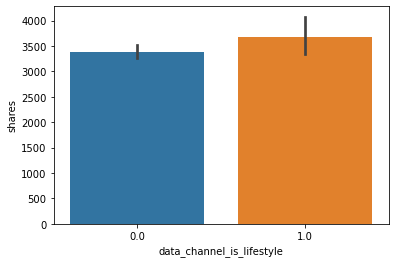

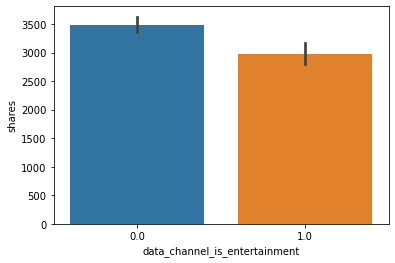

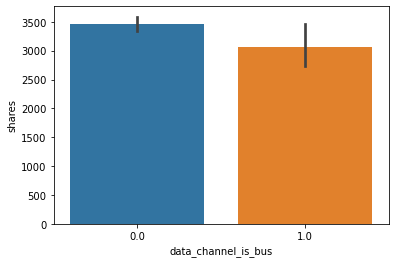

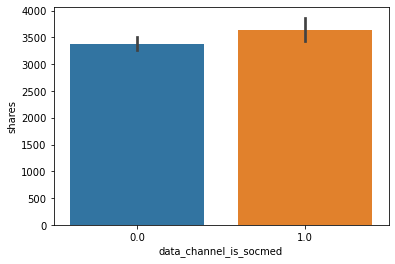

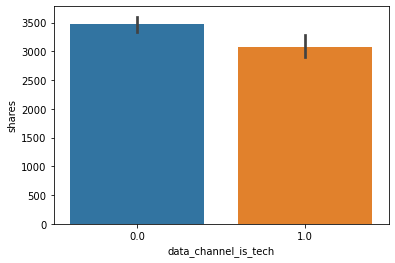

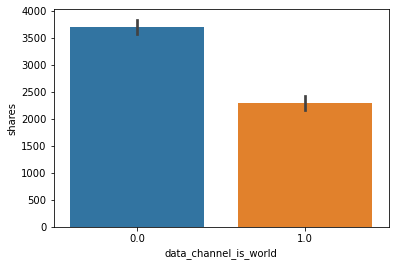

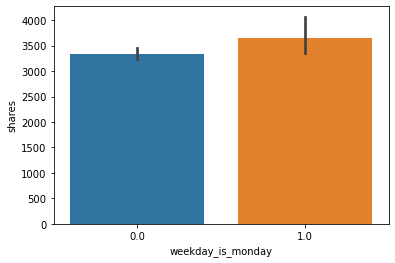

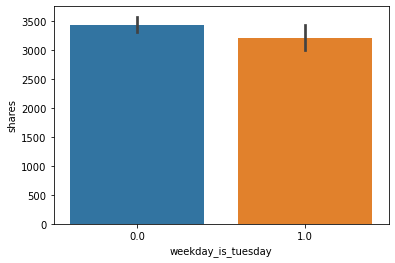

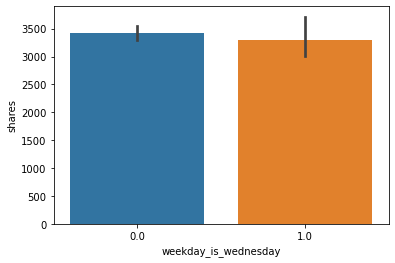

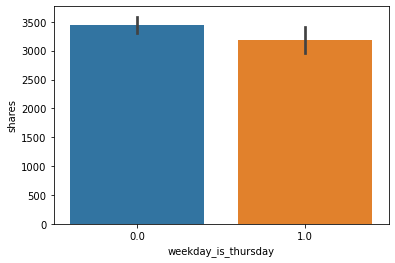

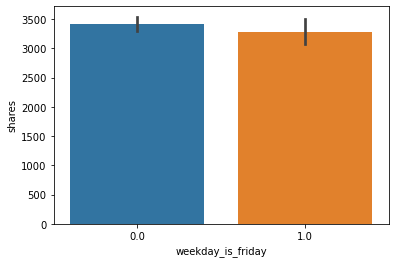

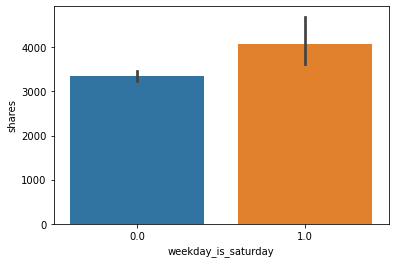

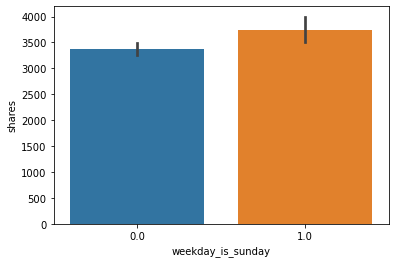

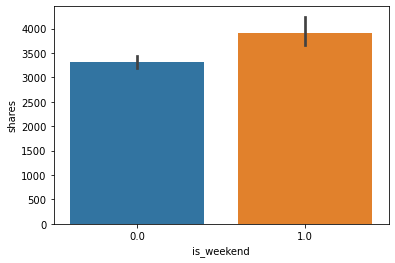

In [60]:
# Visualizing categorical variables (by Daniel He)
cleaned_cat = cleaned.loc[:, ['data_channel_is_lifestyle',
       'data_channel_is_entertainment', 'data_channel_is_bus',
       'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world', 'weekday_is_monday', 'weekday_is_tuesday', 'weekday_is_wednesday',
       'weekday_is_thursday', 'weekday_is_friday', 'weekday_is_saturday',
       'weekday_is_sunday', 'is_weekend', 'shares']]

for x in cleaned_cat.columns:
    if x != 'shares':
        sns.barplot(x= x, y = 'shares', data = cleaned_cat)
        plt.show()

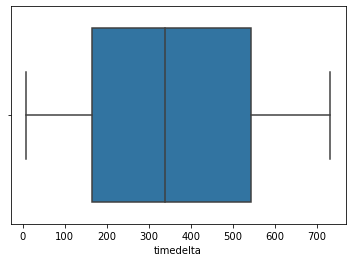

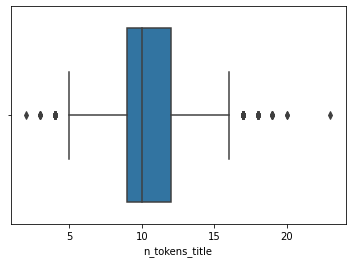

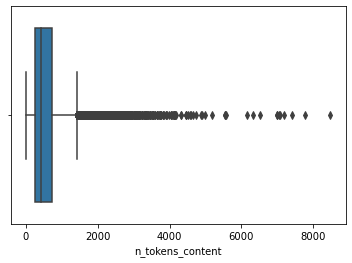

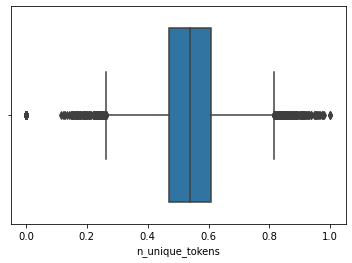

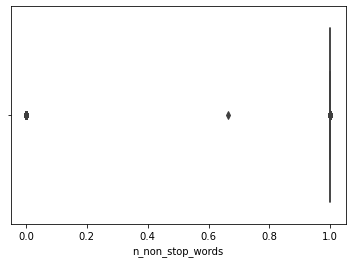

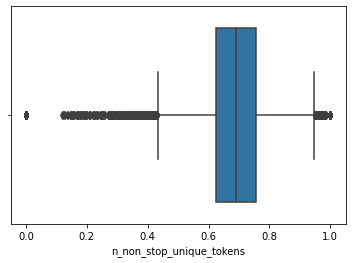

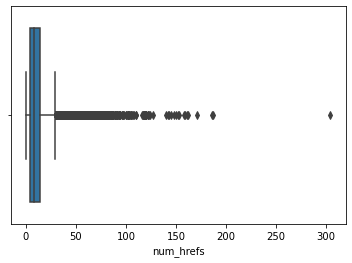

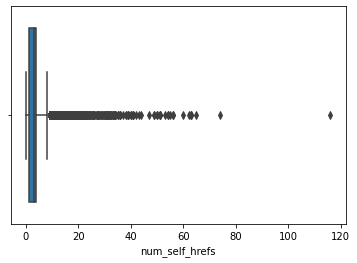

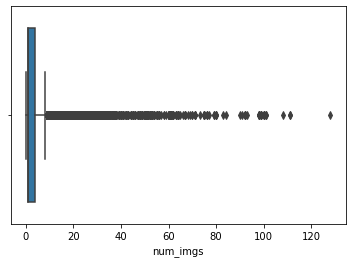

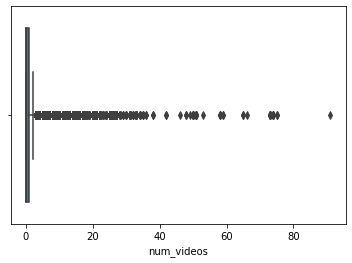

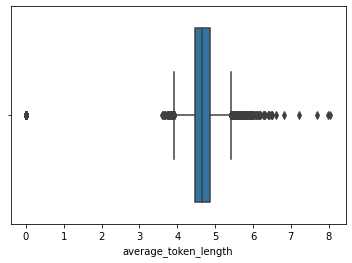

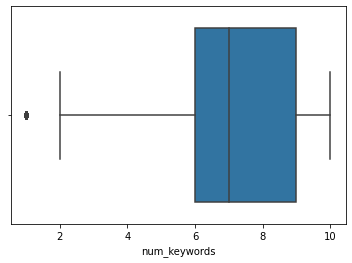

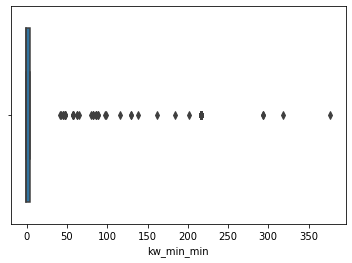

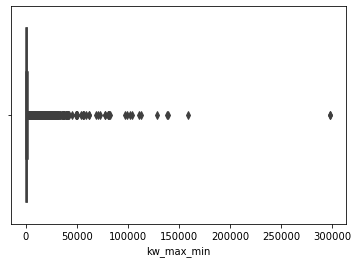

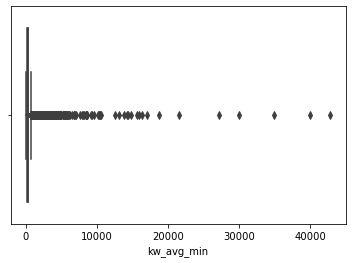

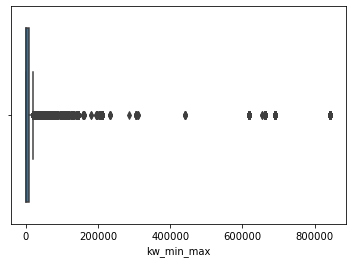

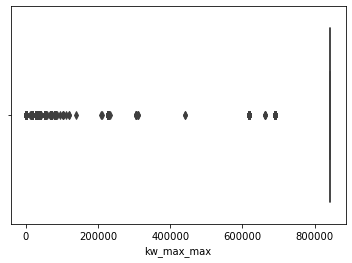

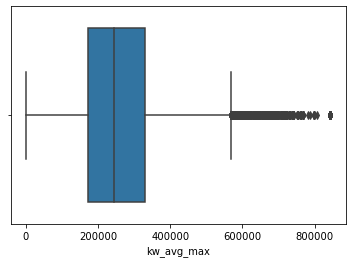

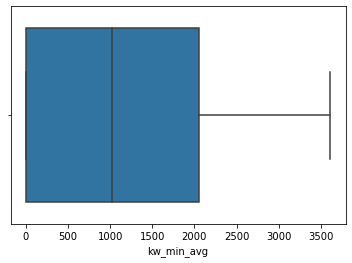

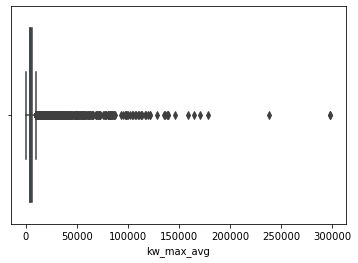

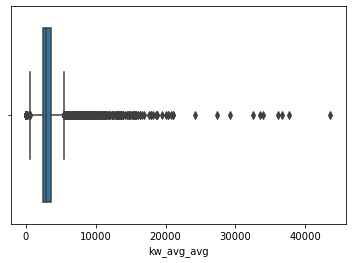

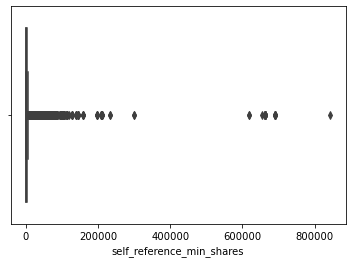

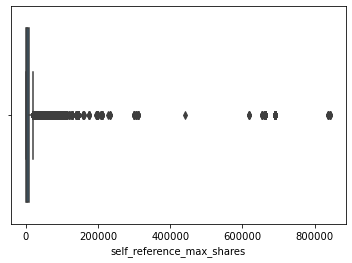

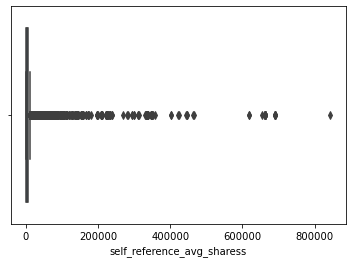

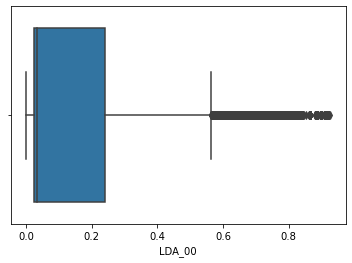

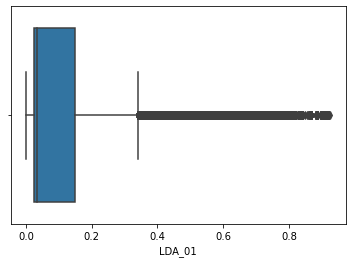

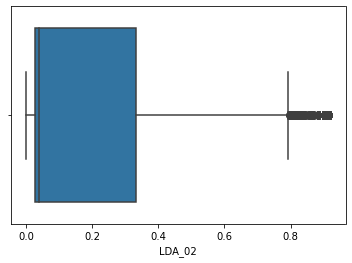

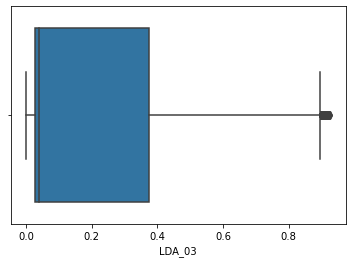

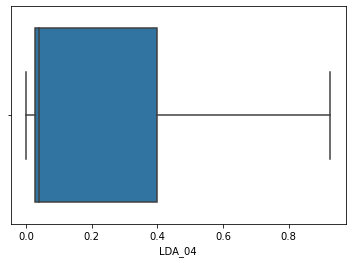

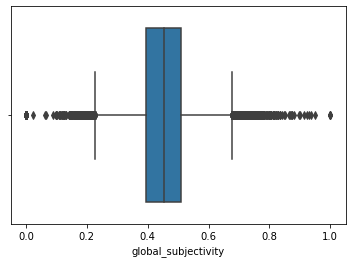

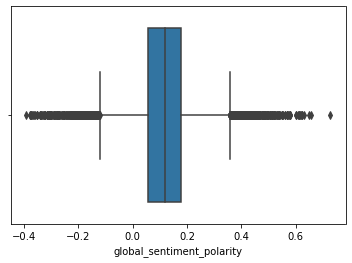

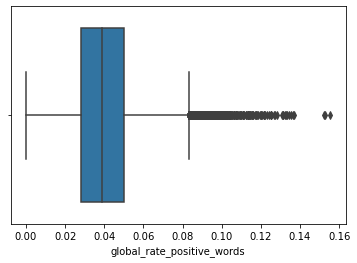

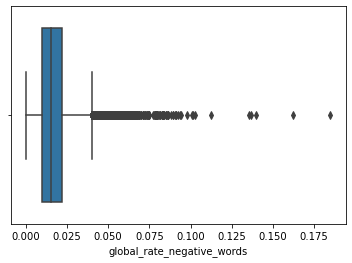

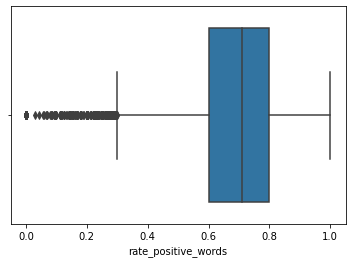

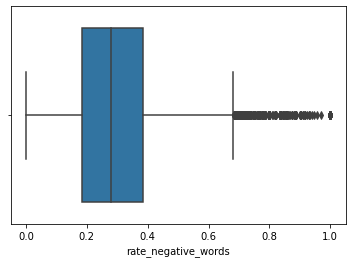

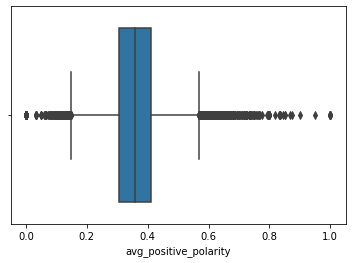

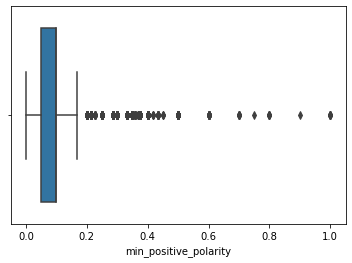

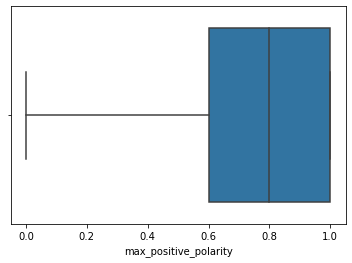

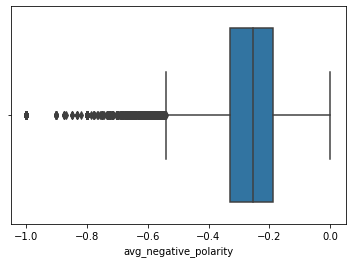

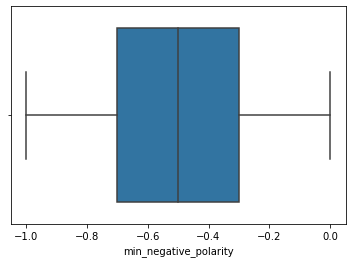

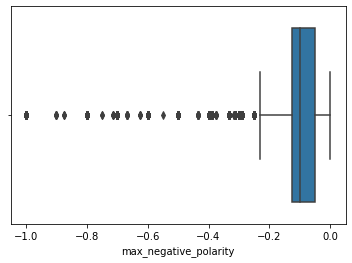

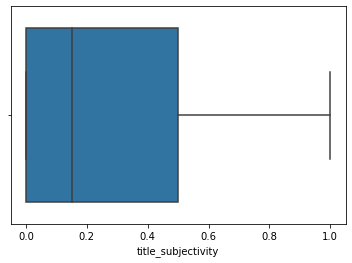

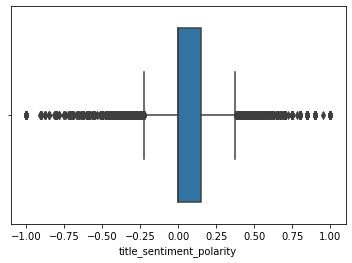

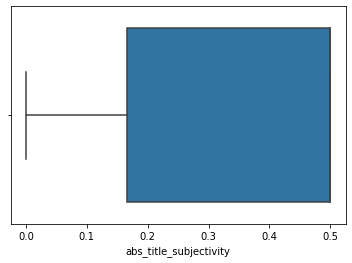

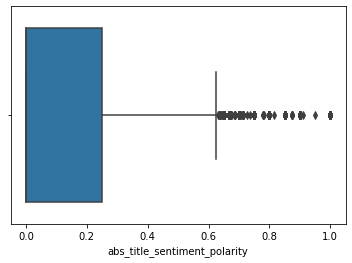

In [62]:
# Visualizing Continious variables (by Daniel He)
cleaned_con = cleaned.drop(['data_channel_is_lifestyle',
       'data_channel_is_entertainment', 'data_channel_is_bus',
       'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world', 'weekday_is_monday', 'weekday_is_tuesday', 'weekday_is_wednesday',
       'weekday_is_thursday', 'weekday_is_friday', 'weekday_is_saturday',
       'weekday_is_sunday', 'is_weekend', 'shares'], axis=1)
for x in cleaned_con:
    sns.boxplot(x= cleaned_con[x])
    plt.show()

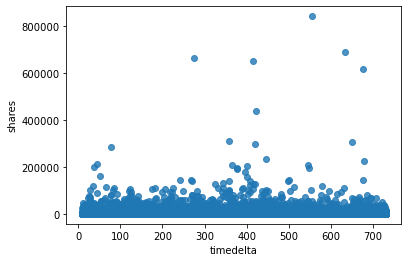

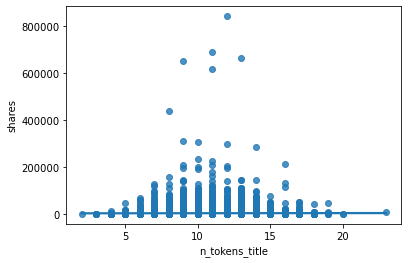

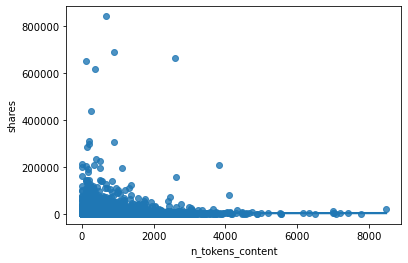

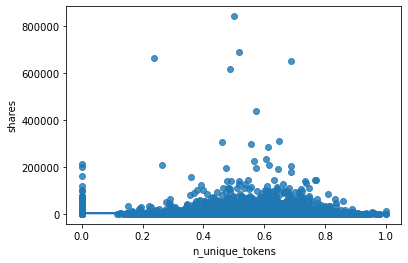

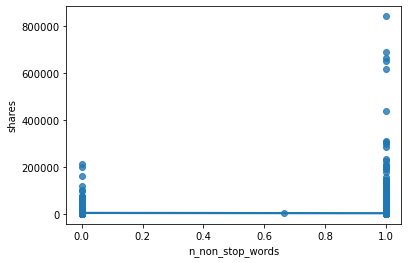

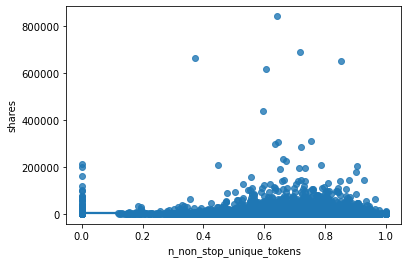

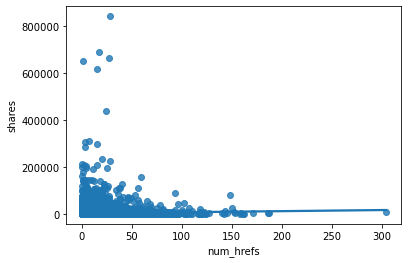

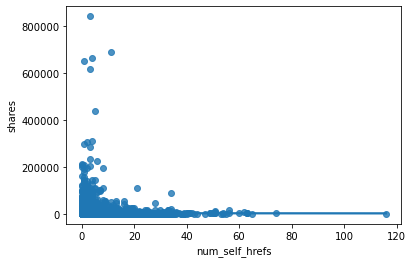

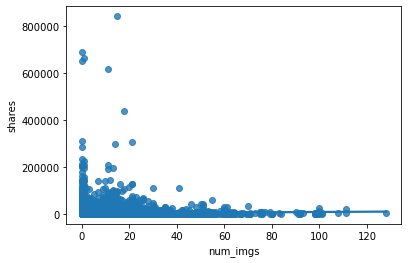

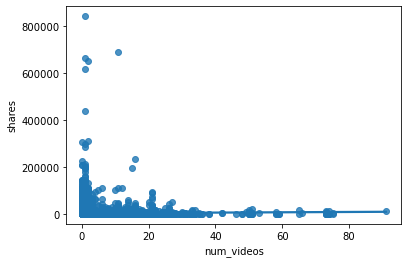

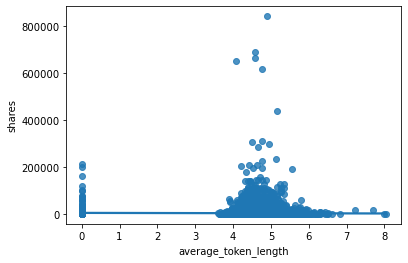

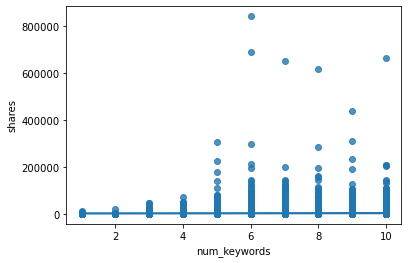

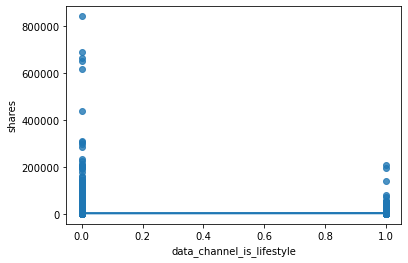

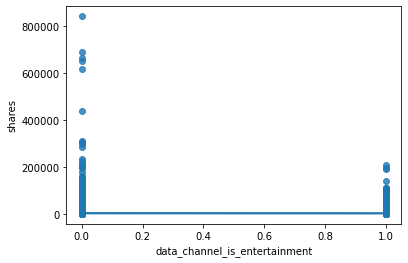

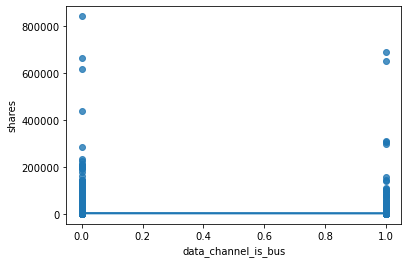

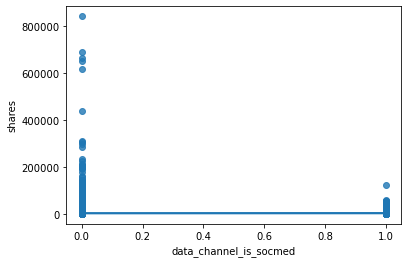

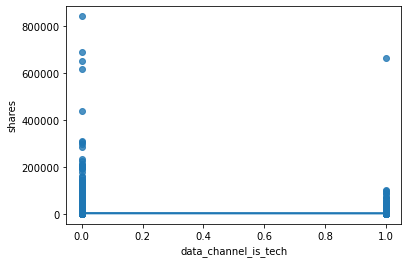

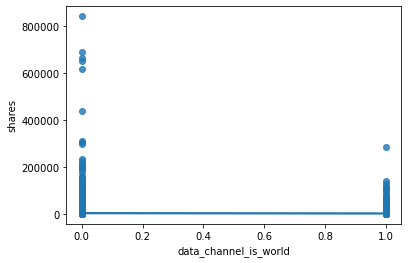

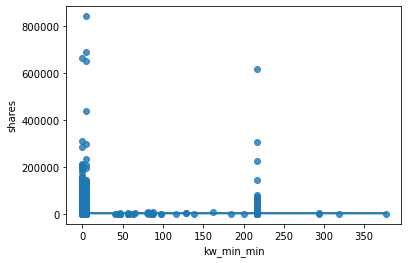

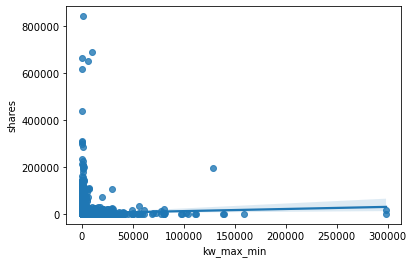

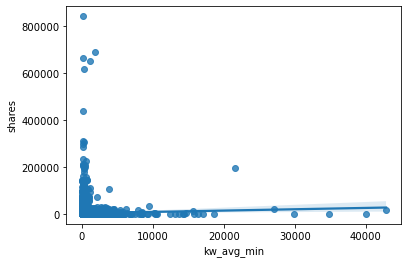

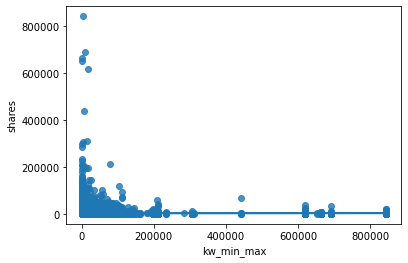

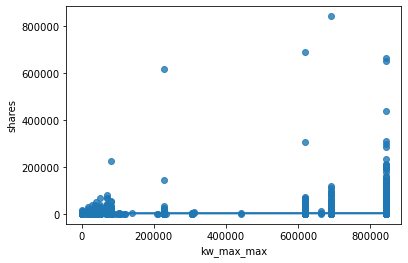

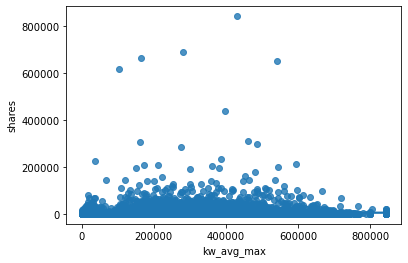

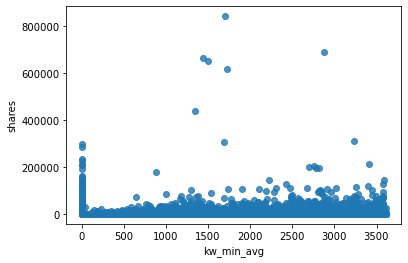

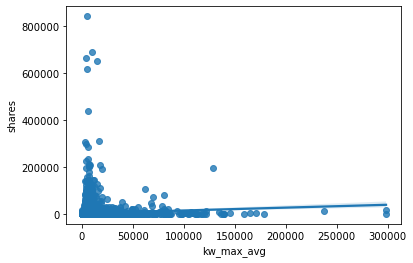

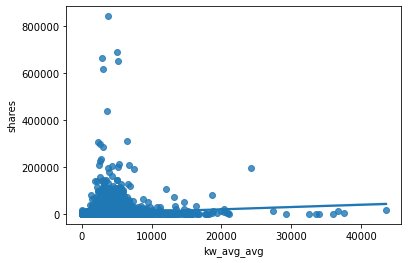

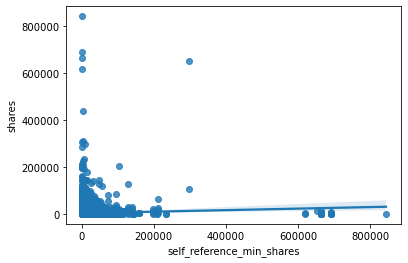

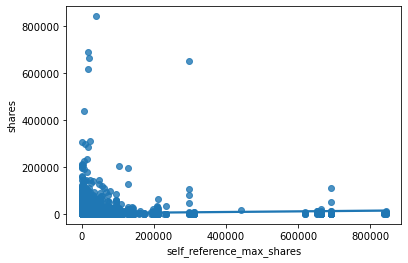

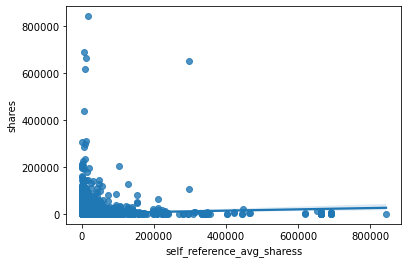

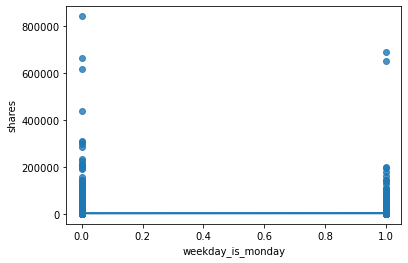

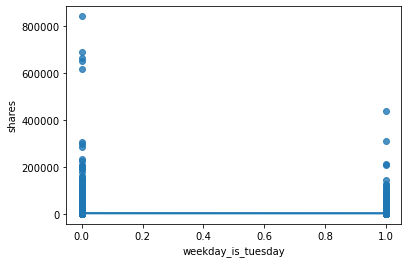

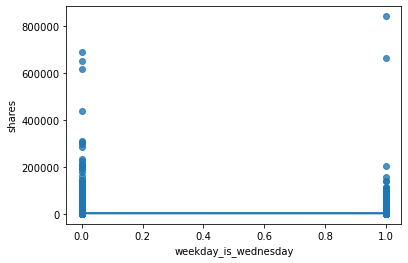

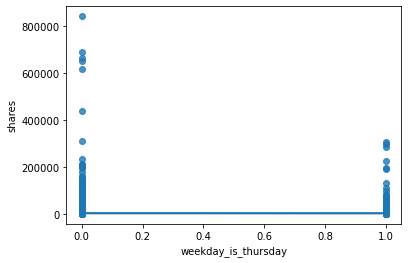

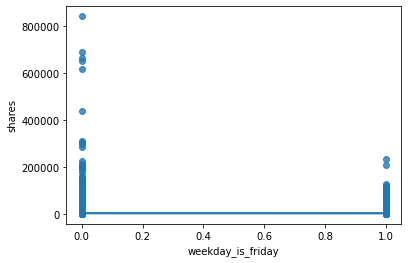

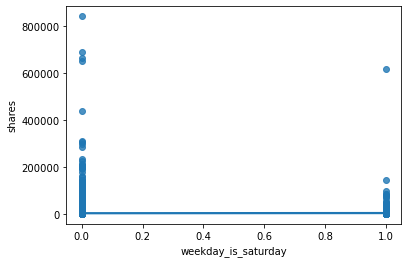

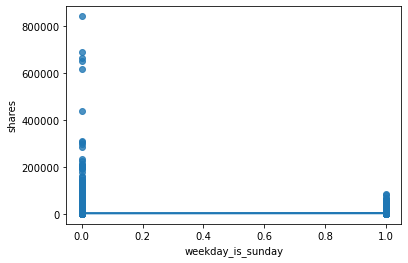

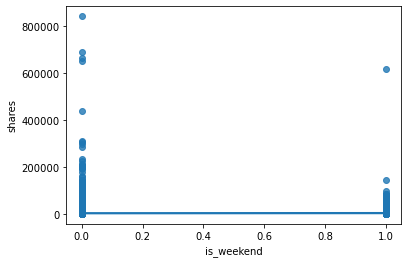

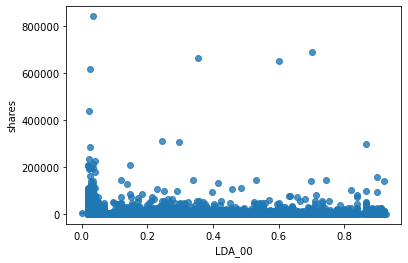

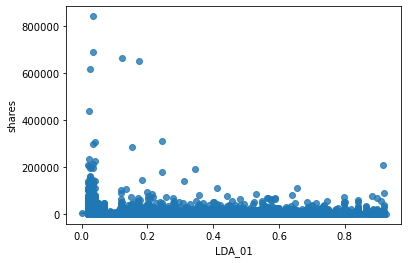

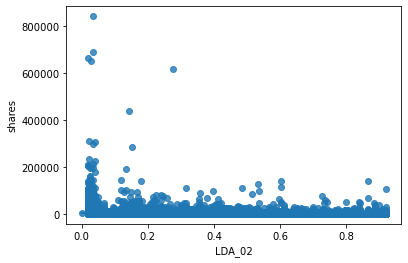

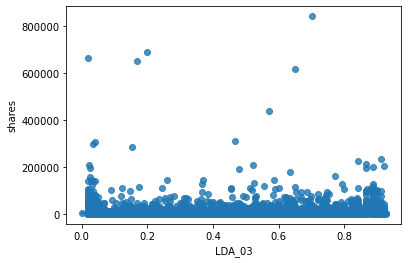

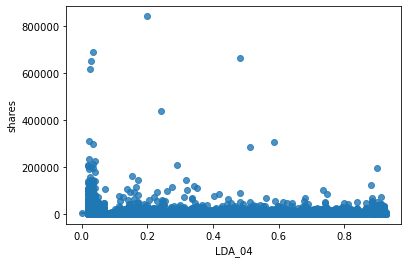

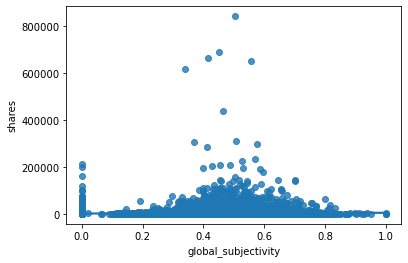

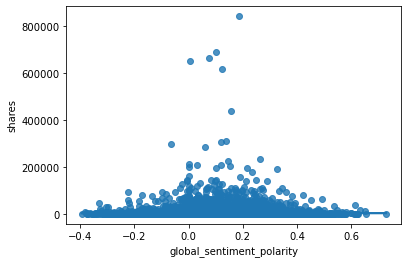

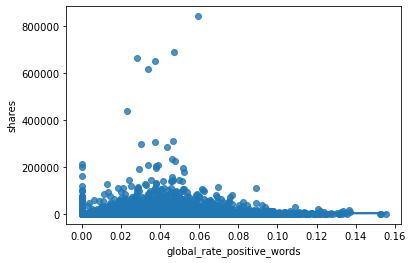

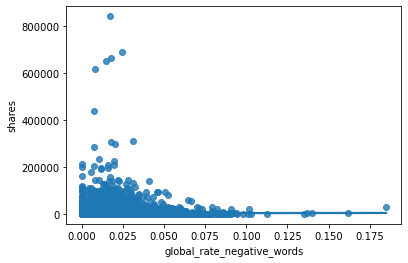

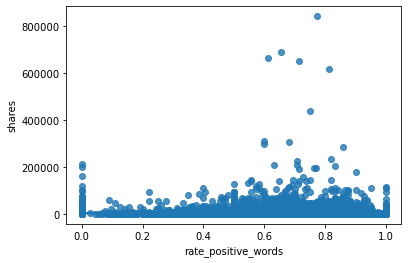

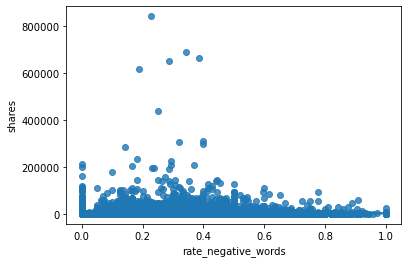

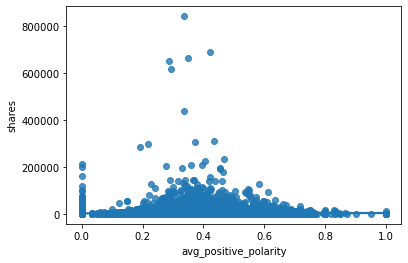

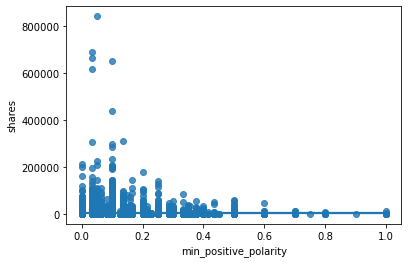

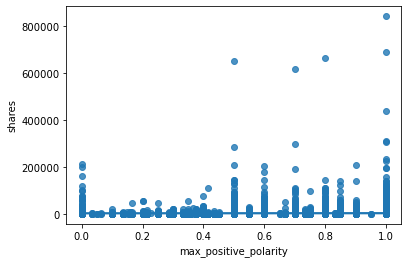

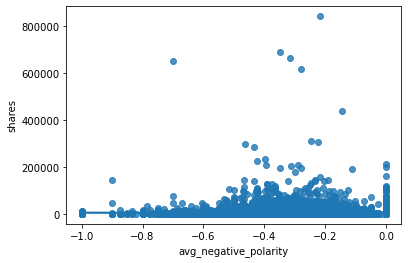

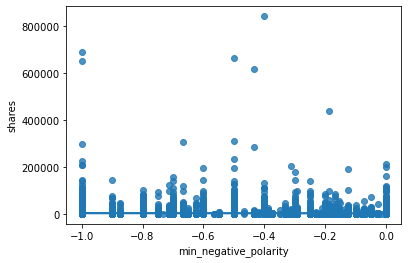

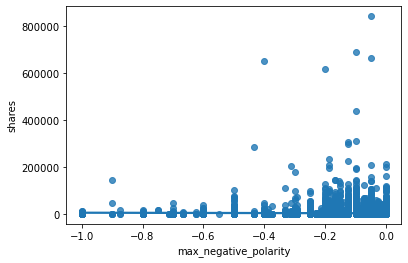

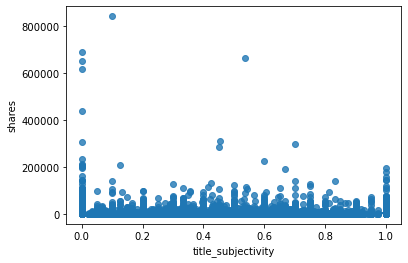

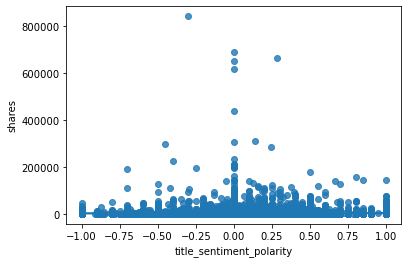

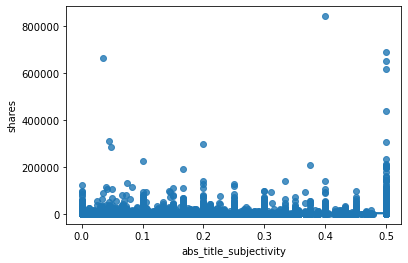

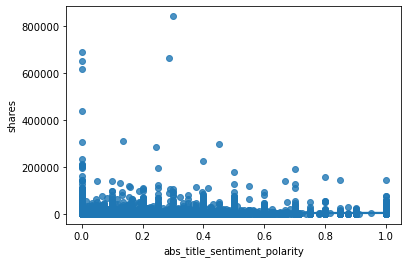

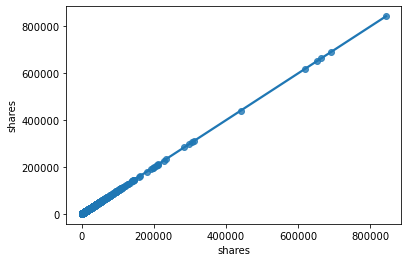

In [63]:
# Visualizing all predictors vs. response variable of shares (by Daniel He)
for x in cleaned:
    sns.regplot(x=x, y= 'shares', data=cleaned)
    plt.show()

## Developing the model: Hyperparameter tuning

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

Put each model in a section of its name and mention the name of the team-member tuning the model. Below is an example:

### Gradient Boosting, XGBoost, LightGBM, and Catboost
*By Daniel He*

### Bagged trees, Random Forest and AdaBoost
*By Sarah Hsu*

### Ridge/Lasso
*By Gemily Wang*

### Decision Tree
*By Anika Kaura*

## Model Ensemble 

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**


### Voting ensemble

### Stacking ensemble(s)

### Ensemble of ensembled models

### Innovative ensembling methods
*(Optional)*

## Conclusions and Recommendations to stakeholder(s)

You may or may not have code to put in this section. Delete this section if it is irrelevant.